# Card generator walkthrough

In this notebook, we walk the reader through how we developed a gold standard for our Taboo card generator based on existing Taboo cards. Then, we show how we applied this gold standard to implement our card generator, and how this card generator can be used to create brand new Taboo-style cards.

## Section 1: Developing a gold standard

It was important to have some gold standard on which to base our work, because otherwise, there would be no way to know how faithful the words that we generated to serve as taboo words (TWs) for any given main word (MW) are to the style of TWs found in the actual game.

This section presents our workflow for developing this gold standard, which consists of an annotated dataset of the types of semantic relations that hold between MWs and TWs on actual Taboo cards.
We show how we used this dataset to generate a distribution of the probabilities of each of the five semantic relations we care about replicating: collocations, synonyms, antonyms, hypernyms, and hyponyms (more detail on this below).

The reason we wanted a probability distribution is so that we could sample from it for each of the five slots on a card, in order to decide which semantic relation should populate each slot.
Then, we can choose some TW that stands in the corresponding semantic relationship to the MW.
This results in cards that are true to the semantic relation distribution seen on actual Taboo cards.

The 240 Taboo cards that our gold standard is based on belong to Elizabeth's family's Canadian edition of Taboo, produced sometime in the 1990s or early 2000s.
These cards were transcribed into the text file `taboo_cards.txt` (found in the current directory).

The module `gs_probdist` contains the functions needed for this section.
(Each function is outfitted with a docstring detailing the parameters and returned values, in case the reader wants more information.)

In [1]:
import gs_probdist as gspd

To start, the function `get_card_dicts()` (using helper functions `read_in()` and `format_cards()`) reads in the transcribed Taboo cards and produces a dictionary, each entry of which represents one card. 
For example, the MW *huddle* is assigned as one of the dictionary's keys, and the corresponding value is a list of *huddle*'s five TWs.

In [2]:
card_dict = gspd.get_card_dicts()
card_dict['huddle']

['gather', 'football', 'group', 'play', 'together']

`get_card_dicts()` provides the input for the function `cards_to_df()`, which converts this dictionary to a `pandas` dataframe.
In this dataframe, each row is a pairing of the MW with each of its TWs.
This format allows for easy annotation of the semantic relationship between each MW/TW pair.
The following cell shows the top five rows of the resulting dataframe, corresponding to one card.

In [3]:
gspd.cards_to_df(card_dict).head()

,mw,tw
0,huddle,gather
1,huddle,football
2,huddle,group
3,huddle,play
4,huddle,together


At this point, we exported this dataframe to a CSV file and manually categorised the following types of semantic relationship between each TW and its MW (annotation guidelines can be found in `gs-annotation-guidelines.txt`):

- **collocations** (i.e. combinations of words at rates more frequent than chance; see Evert 2009)
- **synonyms** (words meaning the same thing)
- **antonyms** (words with opposite meanings)
- **hyponyms** (a subset of a word's meaning, i.e. a more specific version)
- **hypernyms** (a superset of a word's meaning, i.e. a more general version)

We also had a category for cultural references---MWs and TWs relating in a way that requires cultural or world knowledge---and a catch-all "other" category.
We did not try to replicate these two categories, since our focus was on the linguistic aspect of this project.

We chose these five semantic relations since they are fairly easy to operationalise using two tools that we have gotten to know this semester: word2vec word embeddings (for the collocations, since word embeddings represent textual co-occurrence; see Mikolov et al. 2013) and WordNet (for the other four categories; see Fellbaum 2010).

The rest of the functions in `gspd` are used to process the annotated gold standard dataset, which is saved as `gold-std-categorised.csv` in the current directory.
First, `read_in_categorised()` simply processes the csv file into a `pandas` dataframe with one row per MW/TW pairing, a 1 in the column of the category that that pair belongs to, and zeroes everywhere else, as illustrated in the next cell.

In [4]:
goldstd_data = gspd.read_in_categorised()
goldstd_data.head()

,mw,tw,semrel_synonym,semrel_antonym,semrel_hyponym,semrel_hypernym,collocation,cultural_ref,other
0,huddle,gather,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,huddle,football,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,huddle,group,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,huddle,play,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,huddle,together,0.0,0.0,0.0,0.0,1.0,0.0,0.0


This dataframe is used as input for the final two functions of `gspd`: `plot_category_freqs()`, to create the bar plot used in our presentation at the beginning of February (this function also exports the plot to a PDF in the current directory), and the crucial `freq_dist_to_prob_dist()`, which converts the relative frequencies of each category into a probability distribution.
This probability distribution was then used to randomly supply a category for each of the five TW slots, in proportion to that category's actual frequency in the real Taboo cards.

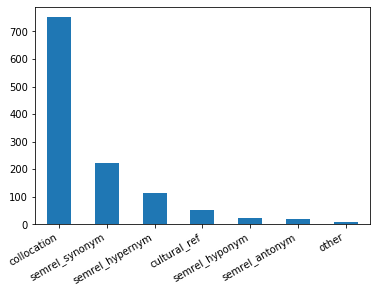

In [17]:
gspd.plot_category_freqs(goldstd_data);

In [6]:
category_prob_dist = gspd.freq_dist_to_prob_dist(goldstd_data)
category_prob_dist

{'collocation': 0.6634275618374559,
 'semrel_synonym': 0.19699646643109542,
 'semrel_hypernym': 0.10159010600706714,
 'semrel_hyponym': 0.020318021201413426,
 'semrel_antonym': 0.0176678445229682}

## Section 2: Determining semantic relations for the given word

At this point, we know the probability of each category being assigned to one TW slot.
However, we still need to actually find the words that belong to these categories for any given MW, so that in the final step, these words can be selected and combined into one card.
This is where the functions in the module `semrel` come in.

In [7]:
import semrel as sr

One major pillar of this module is `make_semrel_dict()`, which takes in the given MW and uses the NLTK interface with WordNet to populate a dictionary with the MW's synonyms, antonyms, hypernyms, and hyponyms.
It uses other functions defined in this module to do this: `get_synonyms()`,  `get_antonyms()`, `get_hypernyms()`, and `get_hyponyms()`.
Two other functions were created for this module, as well: `wd_to_synsets()` (used in `get_synonyms()`), and `synset_to_wd()` (used in `get_hypernyms()` and `get_hyponyms()`).

Two examples of the results of  `make_semrel_dict()` are given below.

In [8]:
sr.make_semrel_dict('sheep')

{'semrel_synonym': set(),
 'semrel_antonym': set(),
 'semrel_hypernym': {'bovid', 'follower', 'simpleton'},
 'semrel_hyponym': {'ewe', 'ram', 'wether'}}

In [9]:
sr.make_semrel_dict('good')

{'semrel_synonym': {'adept',
  'beneficial',
  'commodity',
  'dear',
  'dependable',
  'effective',
  'estimable',
  'full',
  'thoroughly',
  'well'},
 'semrel_antonym': {'bad', 'evil', 'ill'},
 'semrel_hypernym': {'advantage', 'artifact', 'morality', 'quality'},
 'semrel_hyponym': {'basic',
  'beneficence',
  'benefit',
  'benignity',
  'better',
  'desirability',
  'entrant',
  'export',
  'fungible',
  'future',
  'import',
  'kindness',
  'merchandise',
  'middling',
  'optimum',
  'saintliness',
  'salvage',
  'shopping',
  'summum_bonum',
  'virtue',
  'wisdom',
  'worldly_possession',
  'worthiness'}}

Two remarks about the above:

1. WordNet might not contain any words that stand in some semantic relation to the MW (e.g. there are no synonyms or antonyms for *sheep*).
This means that, if one of the five TW slots on a card for *sheep* happens to be assigned the category "synonym" or "antonym", this assignment will be unfulfillable.
We will return to how we deal with these cases in a little while.

2. The word *good* can be an adjective or a noun (singular of *goods*; uncommon, but it exists).
The function `make_semrel_dict()` was designed to capture all parts of speech and all senses of the input word, which is why we have synonyms like *commodity* and also *beneficial*.
We made this decision because, in Taboo, you are not told what part of speech your MW belongs to; you can use any of its senses to try to make your team members guess it (and often this is a very good strategy for English Taboo, where many of the words are homonymous).

The other pillar of this module is `get_collocations()`.
This is a recursive function that uses the word2vec word embeddings to return some number of suitable collocates, which we operationalise as words that word2vec considers to be similar to the main word, due to their frequent use in the same contexts.

"Suitable" is an important word here, since some post-processing has to be done to the words that are returned by gensim's `most_similar()` function.
Words that we do not want on the cards, but that `most_similar()` might unearth, are those that

- contain the string of the main word (e.g. inflectional variations of the MW),
- have a Levenshtein distance of 3 or fewer to the main word (meaning that they are probably typos),
- contain an underscore, which indicates a multi-word unit; these can sometimes get quite strange (e.g. for the MW *kitchen*, one of the results is *virtuoso_violinist_walked* (???)), or
- are already contained in the semantic relations dictionary.

All of these cases are taken care of by `get_collocations()`, which returns a set of suitable collocates whose cardinality is larger than the passed-in integer.

In [10]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [11]:
# No "forbidden words" (the set in the second argument is empty)
sr.get_collocations('flower', set(), model, num_collocates = 3)

{'anthurium', 'blossom', 'chrysanthemum', 'orchid', 'peony', 'tulip'}

In [12]:
# Forbidding "orchid" and "anthurium" (e.g. if they were already in the semantic relations dictionary)
sr.get_collocations('flower', {'orchid', 'anthurium'}, model, num_collocates = 3)

{'blossom', 'chrysanthemum', 'peony', 'tulip'}

*Side note:* The reasoning behind returning (at minimum) some number of suitable collocates is the following.

We sample from the probability distribution from above to decide which semantic relation should hold for each of the five slots on a card.
We do not know in advance how many collocations we will need for each MW; this depends on the number of other semantic relations that this sampling procedure gives us.
We would need zero collocates if all of the sampled semantic relations were synonyms, antonyms, hypernyms, or hyponyms (which is unlikely, but possible), but we would need five if all five of the sampled semantic relations were collocations.

Conceivably, `get_collocations()` could be specified to always return five collocates, no matter what, since that is the maximum number that could be needed for each card.
However, generating more collocations than necessary is inefficient, since for some MWs, even reaching five collocates that pass all the tests above is a laborious job for `most_similar()`.
Therefore, this threshold ensures that the function does as little work as possible.

But where does the recursion come in?
Imagine that we need five collocations, but `most_similar()` returns only three viable options, because the other seven (it returns the top ten by default) were all unsuitable.
Then, we would need to extend the range of most similar words that `most_similar()` returns to beyond the top ten, so that we have more words to choose from.
So, `get_collocations()` checks whether the number of suitable collocates provided in the first iteration is more than the passed-in cardinality threshold (which, in the above example, it is not).
If there are too few suitable collocates in the first bunch, `get_collocations()` increases the number of most similar words to return and calls itself again, checking to see how many words in this extended range pass the tests.
This recursion continues until until the cardinality of the resulting set of collocates surpasses the minimum threshold provided in the `num_collocates` argument.

So, to recap: at this point, we have functions that make a dictionary that contains all of the synonyms, antonyms, hypernyms, and hyponyms from WordNet, as well as a set of collocated words based on the word2vec embeddings.
We also have a probability distribution that tells us how probable it is to find any one of these semantic relations in one TW slot in the final card.
Now all that remains is to put this information together and generate the Taboo cards.

## Section 3: Putting it all together -- Card generation

The module containing the functions for the culmination of the card generator is `cardgen`.

In [13]:
import cardgen as cg

Its workhorse is `card_generator()`, which takes in the desired MW, the dictionary containing the probability distribution from the gold standard, and the gensim model.
It uses the function `select_five_categories()` to generate a list of five semantic relations, one for each slot on the card.
Then, `get_good_label_distrib()` assesses the cardinality of the sets in the semantic relation dictionaries to see if the MW has enough synonyms, say, to fulfill the number of synonyms that `select_five_categories()` has generated.
If not, this label is just replaced by "collocation", since this is the most frequent category, and we can generate as many collocations as we need using `sr.get_collocations()`. 

For example, we saw a case above where *sheep* had no synonyms or antonyms.
If the relation "synonym" were sampled for *sheep*, because this assignment cannot be fulfilled, `get_good_label_distrib()` would replace "synonym" with "collocation".
(It would have been more sophisticated to resample a category according to the probability distribution instead of just assigning "collocation", but this method was much more straightforward, and the word2vec words contain more than just strict collocations in the linguistic sense, anyway.)

At this point, we have a list of categories to populate with TWs, and we know that these categories are fulfillable for our given MW.
Now we randomly select words with the desired semantic relation from the dictionary and fill in the rest with new collocates (this is why the forbidden-words parameter in `sr.get_collocations()` is important: to block already-selected TWs that we chose from the semantic relations dictionary).
The card is returned as a single-entry dictionary, with the MW as a key and the generated list of TWs as the value.

In [14]:
cg.card_generator('hat', category_prob_dist, model)

{'hat': ['wear', 'millinery', 'stetson', 'fedora', 'beanie']}

There is also a function to pretty-print these cards in a more Taboo-like format.
Together, `card_generator()` and `pretty_print()` are wrapped up in `draw_card()`, which simulates drawing a Taboo card from the playing deck.

One of the fun parts of this card generator is that, because of the randomness in the probability distribution and the fact that there are generally more words to choose from than will fit on a card, the cards generated for a given MW are different almost every time.
Let's see an example with the word *hat* again.

In [15]:
cg.draw_card('hat', model)

 ------------------
 |    hat         |
 ------------------
 |    function    |
 |    stetson     |
 |    fedora      |
 |    beanie      |
 |    chapeau     |
 ------------------


Finally, we also built in handling for the case in which the requested main word is not in word2vec's vocabulary; in that case, the following message will be shown.

In [16]:
cg.draw_card('ignominiousness', model)

Sorry, no card can be generated for this word! Please try another one.


## References

Evert, Stefan. 2009. Corpora and collocations. In Anke Lüdeling & Merja Kytö (eds.), *Corpus linguistics. An international handbook*, 1211–1248. Berlin: De Gruyter.

Fellbaum, Christiane. 2010. WordNet. In *Theory and applications of ontology: Computer applications*, 231–243. Dordrecht: Springer.

Mikolov, Tomas, Kai Chen, Greg Corrado & Jeffrey Dean. 2013. Efficient estimation of word representations in vector space. *ICLR 2013.*